In [ ]:
import cv2
import math
import keras
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras import backend as K
from keras import utils
from keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

In [ ]:
num_classes = 10
img_rows,img_cols = 224, 224

# Load training and validation sets
(X_train, Y_train), (X_test, y_test) = cifar10.load_data()

# Resize images to 244x244
X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:][:3000]])
X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:,:,:,:][:3000]])
Y_train = Y_train[:3000]
y_test = y_test[:3000]

# Transform targets to keras compatible format
Y_train = utils.to_categorical(Y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Making all the values range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, Y_train.shape, X_test.shape, y_test.shape

((3000, 224, 224, 3), (3000, 10), (3000, 224, 224, 3), (3000, 10))

In [ ]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,
    filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96, filters_3x3=128,filters_5x5_reduce=16, filters_5x5=32,filters_pool_proj=32, name='inception_3a')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=192,filters_5x5_reduce=32, filters_5x5=96,filters_pool_proj=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96, filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64, name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name='inception_4b')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64, filters_pool_proj=64,name='inception_4c')
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64, filters_pool_proj=64, name='inception_4d')
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool_proj=128, name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 56, 56, 64)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv_2a_3x3/1 (Conv2D)      (None, 56, 56, 64)           4160      ['max_pool_1_3x3/2[

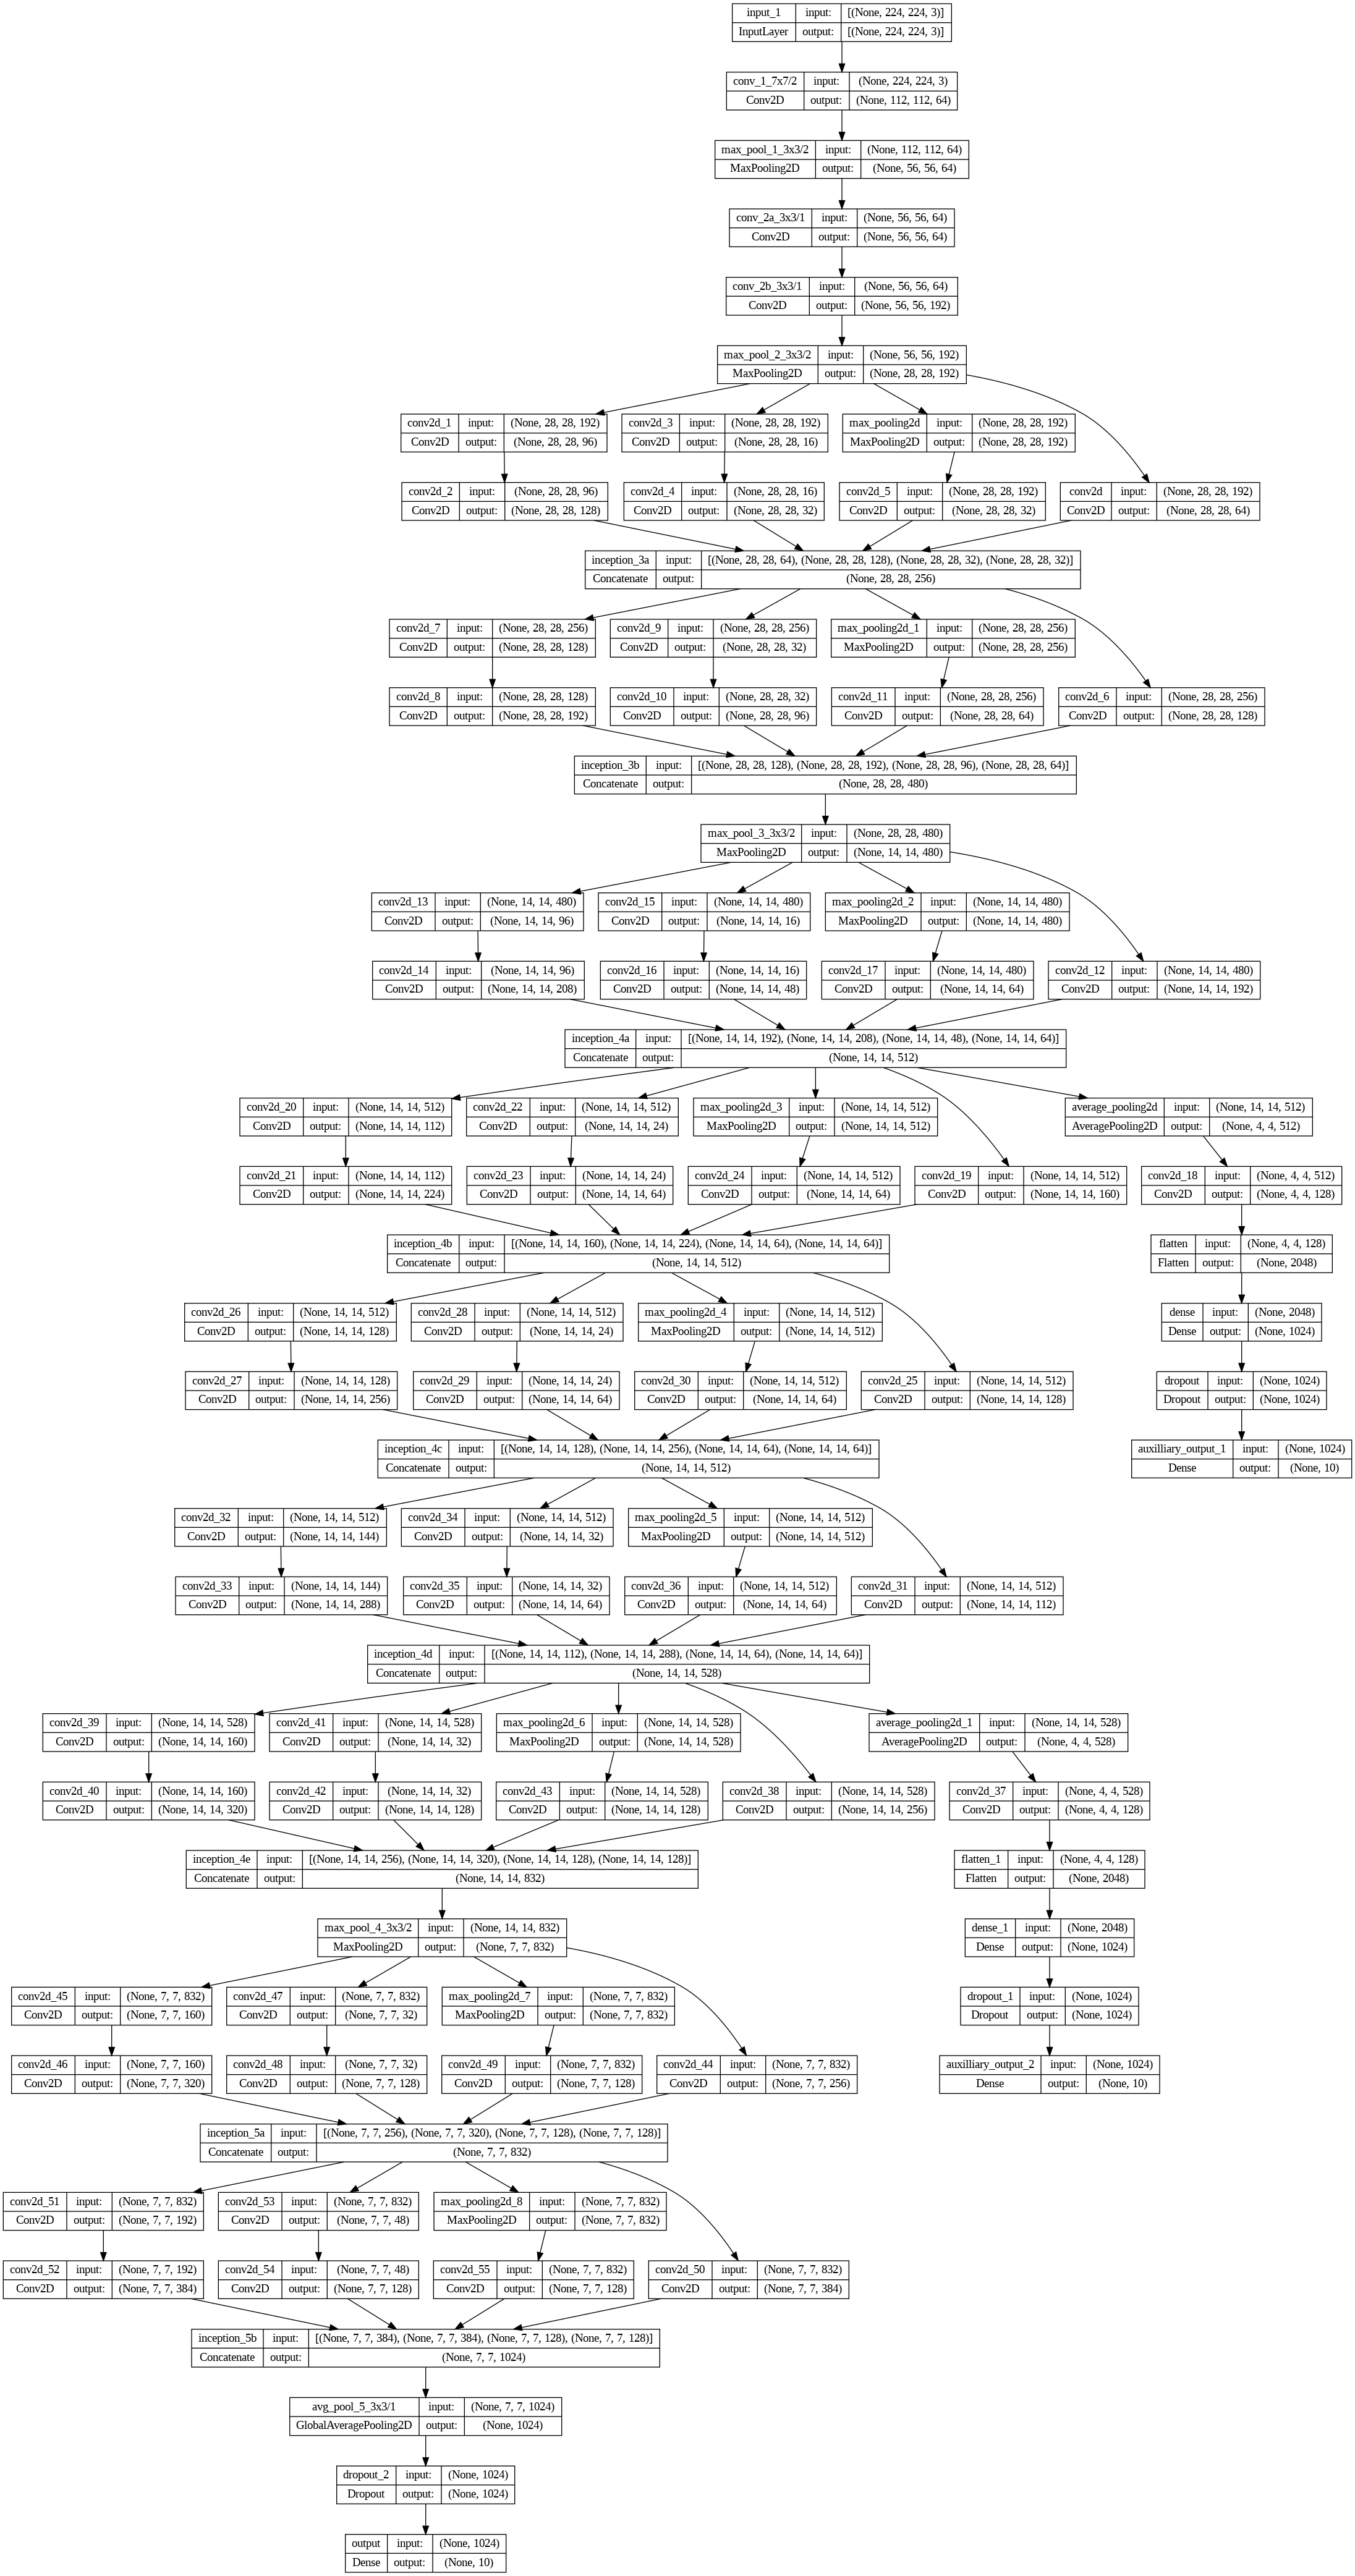

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="my_model.png", show_shapes=True)